In [1]:
import os
import torch
import numpy as np
import torchvision.utils as vutils
from skimage.draw import disk
from skimage.measure import label as skimage_label
from PIL import Image
from torchvision import transforms
from skimage.color import label2rgb
from datasets.utils import DeepLIIFImgMaskDataset, WarwickImgMaskDataset, DeepLIIFBenchmarkDataset, \
WarwickBenchmarkDataset, BCDataImgDataset
from models import Generator, CustomUnet, load_optimal_hyperparameters
from postprocessing import compute_watershed, compute_morphological_operations

# DeepLIIF

In [2]:
data_path = "/path/to/deepliif"

In [3]:
dataset_ihc_path = os.path.join(data_path, "DeepLIIF_Testing_Set")
dataset_ihc = DeepLIIFImgMaskDataset(dataset_ihc_path,
                                     transforms.Compose([transforms.ToTensor(),
                                                         transforms.Normalize(
                                                         (0.5, 0.5, 0.5),
                                                         (0.5, 0.5, 0.5))]),                  
                                     mask_transform=transforms.ToTensor())

### IHC image

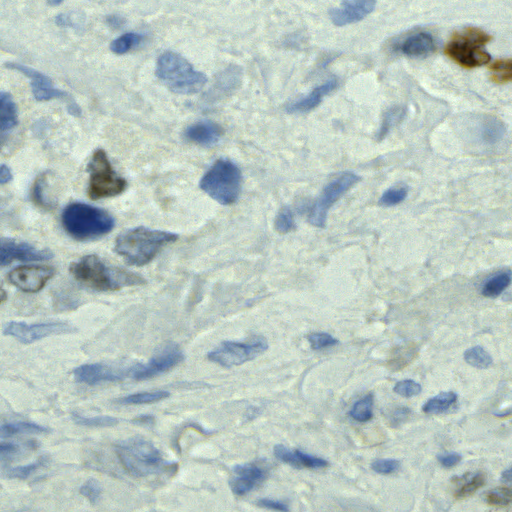

<Figure size 1152x1152 with 0 Axes>

In [10]:
i = 450# 30, 450, 209, 6, 465
img, mask = dataset_ihc[i]
Image.fromarray((np.transpose((img*0.5+0.5).numpy(),(1,2,0))*255).astype(np.uint8))

### Ground Truth

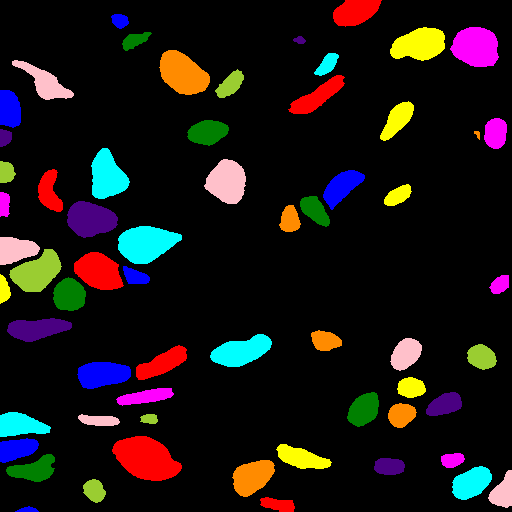

<Figure size 1152x1152 with 0 Axes>

In [11]:
Image.fromarray((label2rgb(skimage_label(mask.squeeze(0).numpy()),bg_label = 0,bg_color="black", alpha=0.9)*255).astype(np.uint8))

### Proposed

In [119]:
model = Generator()
model.eval()
checkpoint = torch.load("./pretrained_models/proposed_deepliif.pt")
model.load_state_dict(checkpoint['generator_ihc_to_mask_state_dict'])

initialize network with normal


<All keys matched successfully>

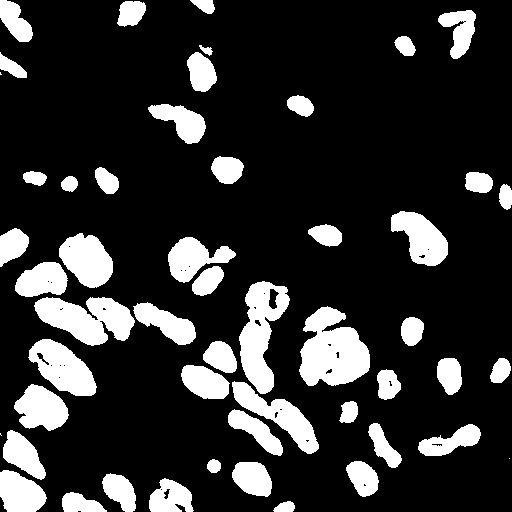

<Figure size 1152x1152 with 0 Axes>

In [120]:
pred_S = model(img.unsqueeze(0))
pred = (pred_S>0.5).float()
Image.fromarray((pred.numpy().squeeze()*255).astype("uint8"))
#pred_postprocessed = compute_watershed(compute_morphological_operations(pred.squeeze().numpy(), erosion=False))
#Image.fromarray((label2rgb(pred_postprocessed,bg_label = 0,bg_color="black", alpha=0.9)*255).astype(np.uint8))

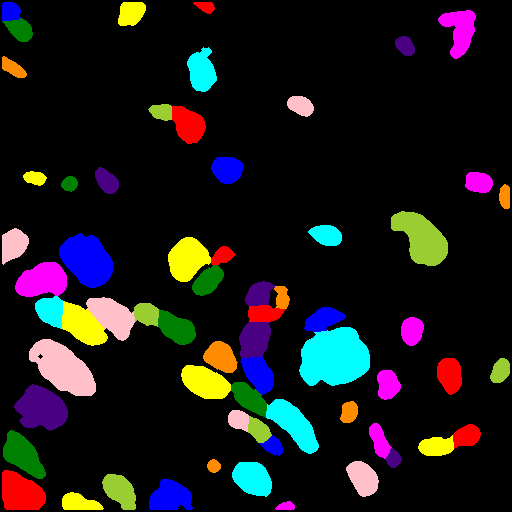

<Figure size 1152x1152 with 0 Axes>

In [121]:
pred_postprocessed = compute_watershed(compute_morphological_operations(pred.squeeze().numpy(), erosion=False))
Image.fromarray((label2rgb(pred_postprocessed,bg_label = 0,bg_color="black", alpha=0.9)*255).astype(np.uint8))

In [122]:
model = Generator(input_nc=1, output_nc=3, segmentation=False)
model.eval()
checkpoint = torch.load("./pretrained_models/proposed_deepliif.pt")
model.unet_model.load_state_dict(checkpoint['generator_mask_to_ihc_state_dict'])

initialize network with normal


<All keys matched successfully>

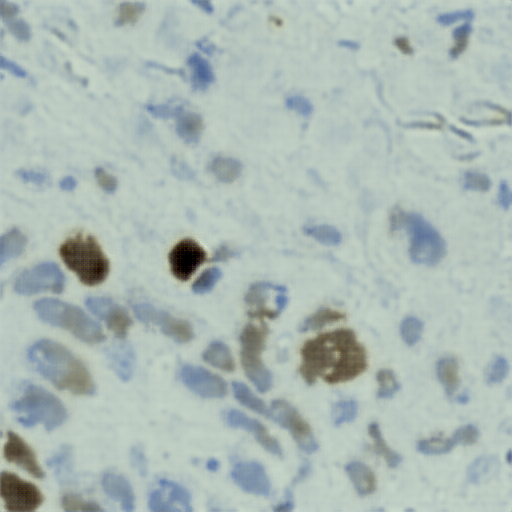

<Figure size 1152x1152 with 0 Axes>

In [123]:
pred = model(pred_S).detach().squeeze()
Image.fromarray((np.transpose(np.clip((pred.numpy()*0.5+0.5),0,1)*255, (1,2,0))).astype(np.uint8))

### Unet

In [124]:
optimal_parameters = load_optimal_hyperparameters("./pretrained_models/optimal_parameters.pickle")
model = CustomUnet(ngf=optimal_parameters["ngf"])
checkpoint = torch.load("./pretrained_models/unet_DeepLIIF.pt")
model.eval()
model.load_state_dict(checkpoint)

initialize network with normal


<All keys matched successfully>

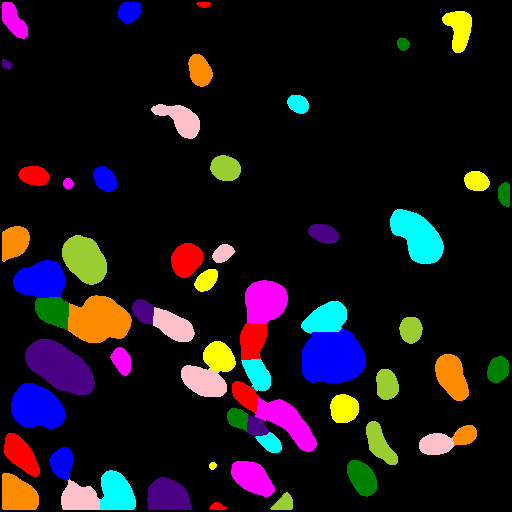

<Figure size 1152x1152 with 0 Axes>

In [125]:
pred = model(img.unsqueeze(0))
pred = (pred>0.5).float()
pred_postprocessed = compute_watershed(compute_morphological_operations(pred.squeeze().numpy(), erosion=False))
Image.fromarray((label2rgb(pred_postprocessed,bg_label = 0,bg_color="black", alpha=0.9)*255).astype(np.uint8))

### Stardist

In [115]:
benchmark_path_Stardist = "path/to/deepliif/stardist/"

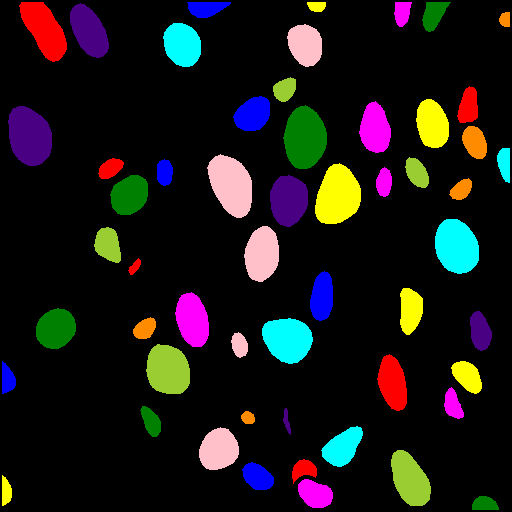

<Figure size 1152x1152 with 0 Axes>

In [116]:
dataset_Stardist = DeepLIIFBenchmarkDataset(benchmark_path_Stardist, dataset_ihc_path,
                                            mask_transform=transforms.ToTensor(),
                                            gt_transform=transforms.ToTensor())
pred = dataset_Stardist[i][0]
Image.fromarray((label2rgb(skimage_label(np.array(pred.squeeze(0))),bg_label = 0,bg_color="black", alpha=0.9)*255).astype(np.uint8))

### Tresholding

In [15]:
benchmark_path_Thresholding = "path/to/deepliif/thresh_otsu_grayscale"

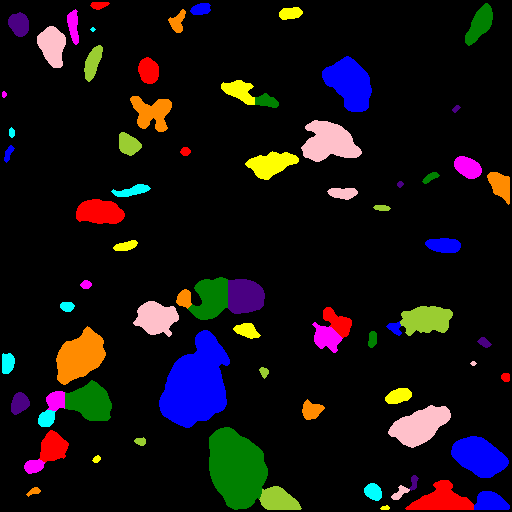

<Figure size 1152x1152 with 0 Axes>

In [16]:
dataset_Thresholding = DeepLIIFBenchmarkDataset(benchmark_path_Thresholding, dataset_ihc_path,
                                            mask_transform=transforms.ToTensor(),
                                            gt_transform=transforms.ToTensor())
pred = dataset_Thresholding[i][0]
pred_postprocessed = compute_watershed(compute_morphological_operations(pred.squeeze().numpy(), erosion=False))
Image.fromarray((label2rgb(pred_postprocessed, bg_label = 0,bg_color="black", alpha=0.9)*255).astype(np.uint8))

### Nuclick

In [17]:
benchmark_path_Nuclick = "path/to/deepliif/nuclick"

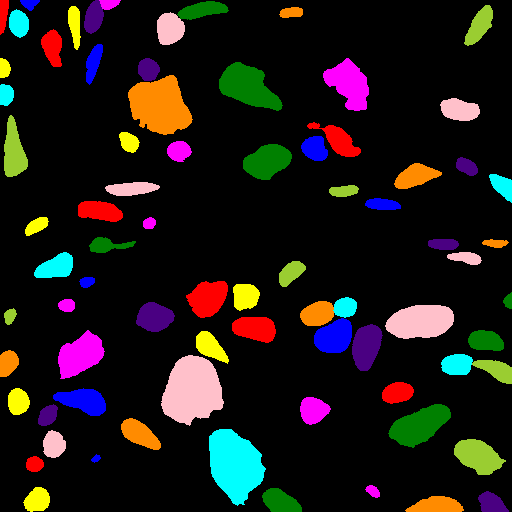

<Figure size 1152x1152 with 0 Axes>

In [18]:
dataset_Nuclick = DeepLIIFBenchmarkDataset(benchmark_path_Nuclick, dataset_ihc_path,
                                            mask_transform=transforms.ToTensor(),
                                            gt_transform=transforms.ToTensor())
pred = dataset_Nuclick[i][0]
Image.fromarray((label2rgb(np.array(pred.squeeze(0)),bg_label = 0,bg_color="black", alpha=0.9)*255).astype(np.uint8))

# Warwick

In [140]:
data_path = "/path/to/warwick"

In [141]:
files = [os.path.join(data_path, "ground_truths", file) for file in os.listdir(os.path.join(data_path, "ground_truths"))]

In [161]:
dataset_ihc_images_path = os.path.join(data_path, "images")
dataset_ihc_masks_path = os.path.join(data_path, "ground_truths")
dataset_ihc = WarwickImgMaskDataset(dataset_ihc_images_path, dataset_ihc_masks_path,
                                    img_transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.Normalize(
                                                                      (0.5, 0.5, 0.5),
                                                                      (0.5, 0.5, 0.5))]),
                                    mask_transform=transforms.ToTensor())

### IHC image

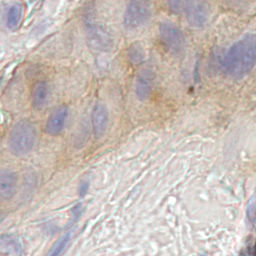

<Figure size 1152x1152 with 0 Axes>

In [212]:
i = 22 # 22, 27, 42, 60
img, mask = dataset_ihc[i]
Image.fromarray((np.transpose((img*0.5+0.5).numpy(),(1,2,0))*255).astype(np.uint8))

### Ground Truth

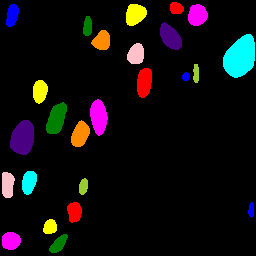

<Figure size 1152x1152 with 0 Axes>

In [213]:
Image.fromarray((label2rgb(skimage_label(mask.squeeze(0).numpy()),bg_label = 0,bg_color="black", alpha=0.9)*255).astype(np.uint8))

### Proposed

In [214]:
model = Generator()
#model.eval()
checkpoint = torch.load("./pretrained_models/proposed_warwick.pt")
model.load_state_dict(checkpoint['generator_ihc_to_mask_state_dict'])

initialize network with normal


<All keys matched successfully>

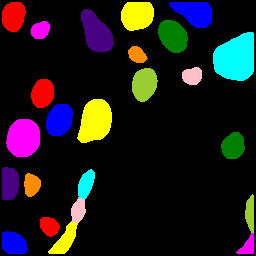

<Figure size 1152x1152 with 0 Axes>

In [215]:
pred = model(img.unsqueeze(0))
pred = (pred>0.5).float()
pred_postprocessed = compute_watershed(compute_morphological_operations(pred.squeeze().numpy(), erosion=False))
Image.fromarray((label2rgb(pred_postprocessed,bg_label = 0,bg_color="black", alpha=0.9)*255).astype(np.uint8))

### Stardist

In [216]:
benchmark_path_Stardist = "/path/to/warwick/stardist"

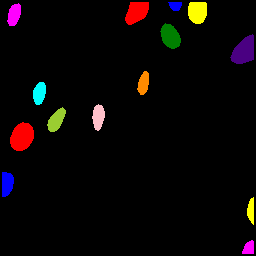

<Figure size 1152x1152 with 0 Axes>

In [217]:
dataset_Stardist = WarwickBenchmarkDataset(benchmark_path_Stardist, dataset_ihc_masks_path,
                                            mask_transform=transforms.ToTensor(),
                                            gt_transform=transforms.ToTensor())
pred = dataset_Stardist[i][0]
Image.fromarray((label2rgb(skimage_label(np.array(pred.squeeze(0))),bg_label = 0,bg_color="black", alpha=0.9)*255).astype(np.uint8))

### Thresholding

In [198]:
benchmark_path_Thresholding = "path/to/warwick/thresh"

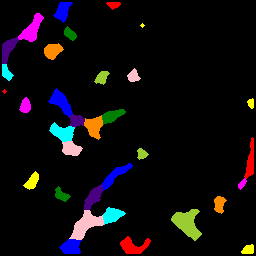

<Figure size 1152x1152 with 0 Axes>

In [199]:
dataset_Thresholding = WarwickBenchmarkDataset(benchmark_path_Thresholding, dataset_ihc_masks_path,
                                            mask_transform=transforms.ToTensor(),
                                            gt_transform=transforms.ToTensor())
pred = dataset_Thresholding[i][0]
pred_postprocessed = compute_watershed(compute_morphological_operations(pred.squeeze().numpy(), erosion=True))
Image.fromarray((label2rgb(pred_postprocessed, bg_label = 0,bg_color="black", alpha=0.9)*255).astype(np.uint8))

### Nuclick

In [200]:
benchmark_path_Nuclick = "path/to/warwick/nuclick"

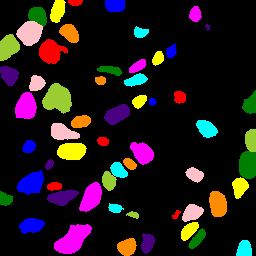

<Figure size 1152x1152 with 0 Axes>

In [201]:
dataset_Nuclick = WarwickBenchmarkDataset(benchmark_path_Nuclick, dataset_ihc_masks_path,
                                            mask_transform=transforms.ToTensor(),
                                            gt_transform=transforms.ToTensor())
pred = dataset_Nuclick[i][0]
Image.fromarray((label2rgb(np.array(pred.squeeze(0)),bg_label = 0,bg_color="black", alpha=0.9)*255).astype(np.uint8))

# BCDataset

In [126]:
data_path = "/path/to/BCData/"

In [127]:
dataset_ihc_images_path = os.path.join(data_path, "images/test")
dataset_ihc_gt_points_path = os.path.join(data_path, "annotations/test")
dataset_ihc = BCDataImgDataset(dataset_ihc_images_path, dataset_ihc_gt_points_path, center_crop = True,
                               transform=transforms.Compose([transforms.CenterCrop((512,512)),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize(
                                                             (0.5, 0.5, 0.5),
                                                             (0.5, 0.5, 0.5))]))

### IHC image

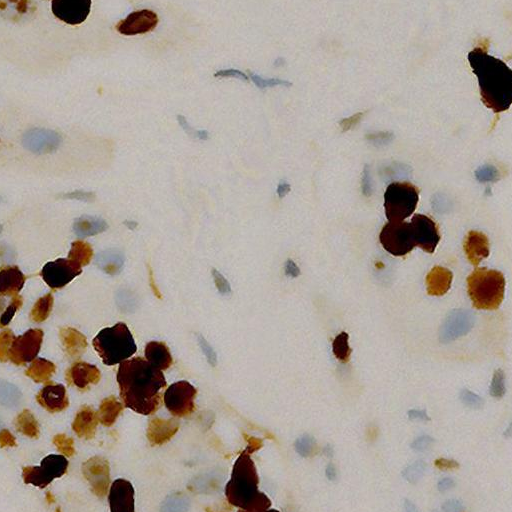

<Figure size 1152x1152 with 0 Axes>

In [128]:
i = 19 #179, 135, 48, 19 
img = dataset_ihc[i]
gt = dataset_ihc.gt_points[i]
Image.fromarray((np.transpose((img*0.5+0.5).numpy(),(1,2,0))*255).astype(np.uint8))

### Ground truth

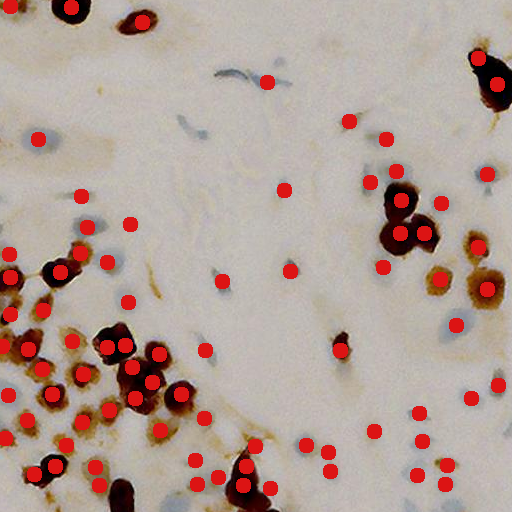

In [129]:
im = (np.transpose((img*0.5+0.5).numpy(),(1,2,0))*255).astype(np.uint8)
for center_x, center_y in zip(gt[:,0], gt[:,1]):
    circx, circy = disk((center_x, center_y), 8,
                                    shape=im.shape)
    im[circx, circy] = (220, 20, 20)
Image.fromarray(im)

### Proposed

In [136]:
model = Generator()
model.eval()
checkpoint = torch.load("./pretrained_models/proposed_deepliif.pt")
model.load_state_dict(checkpoint['generator_ihc_to_mask_state_dict'])

initialize network with normal


<All keys matched successfully>

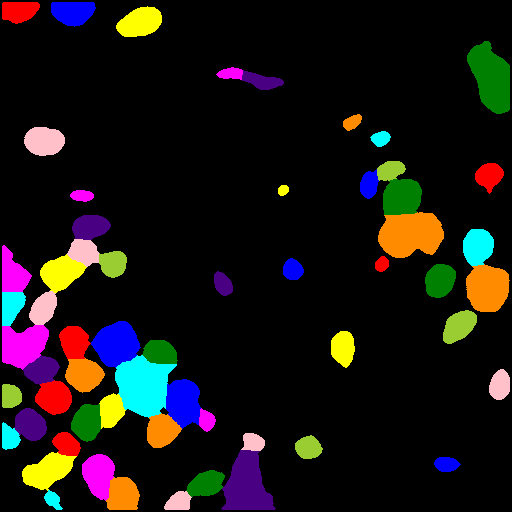

<Figure size 1152x1152 with 0 Axes>

In [137]:
pred = model(img.unsqueeze(0))
pred = (pred>0.5).float()
pred_postprocessed = compute_watershed(compute_morphological_operations(pred.squeeze().numpy(), erosion=False))
Image.fromarray((label2rgb(pred_postprocessed,bg_label = 0,bg_color="black", alpha=0.9)*255).astype(np.uint8))

### Unet

In [134]:
optimal_parameters = load_optimal_hyperparameters("./pretrained_models/optimal_parameters.pickle")
model = CustomUnet(ngf=optimal_parameters["ngf"])
checkpoint = torch.load("./pretrained_models/unet_DeepLIIF.pt")
model.eval()
model.load_state_dict(checkpoint)

initialize network with normal


<All keys matched successfully>

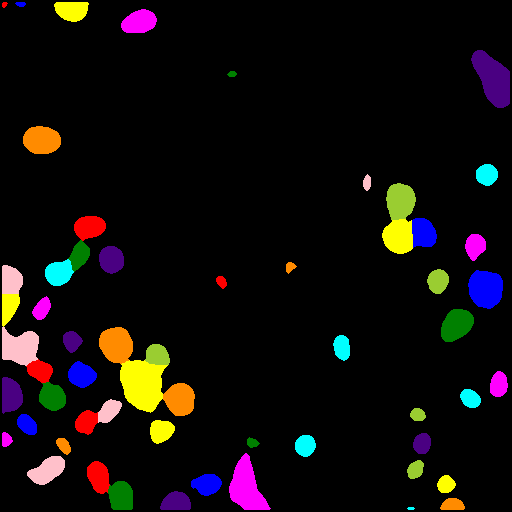

<Figure size 1152x1152 with 0 Axes>

In [135]:
pred = model(img.unsqueeze(0))
pred = (pred>0.5).float()
pred_postprocessed = compute_watershed(compute_morphological_operations(pred.squeeze().numpy(), erosion=False))
Image.fromarray((label2rgb(pred_postprocessed,bg_label = 0,bg_color="black", alpha=0.9)*255).astype(np.uint8))

### Stardist

In [138]:
benchmark_path_Stardist = "/path/to/BCData/stardist"

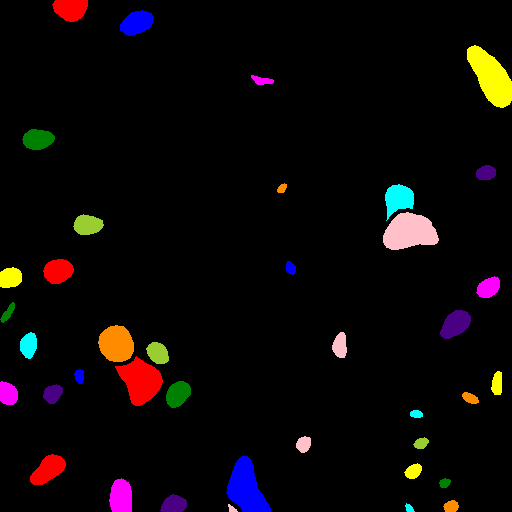

<Figure size 1152x1152 with 0 Axes>

In [139]:
dataset_Stardist = DeepLIIFBenchmarkDataset(benchmark_path_Stardist, dataset_ihc_images_path,
                                            mask_transform=transforms.Compose([transforms.CenterCrop((512,512)),
                                                                               transforms.ToTensor()]),
                                            gt_transform=transforms.Compose([transforms.CenterCrop((512,512)),
                                                                               transforms.ToTensor()]),)
pred = dataset_Stardist[i][0]
Image.fromarray((label2rgb(skimage_label(np.array(pred.squeeze(0))),bg_label = 0,bg_color="black", alpha=0.9)*255).astype(np.uint8))

### Nuclick

In [399]:
benchmark_path_Nuclick = "/path/to/BCData/nuclick"

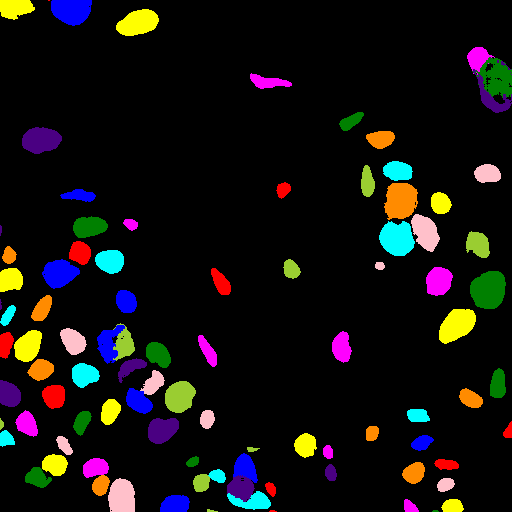

<Figure size 1152x1152 with 0 Axes>

In [410]:
dataset_Nuclick = DeepLIIFBenchmarkDataset(benchmark_path_Nuclick, dataset_ihc_images_path,
                                            mask_transform=transforms.Compose([transforms.CenterCrop((512,512)),
                                                                               transforms.ToTensor()]),
                                            gt_transform=transforms.Compose([transforms.CenterCrop((512,512)),
                                                                               transforms.ToTensor()]),)
pred = dataset_Nuclick[0][0]
Image.fromarray((label2rgb(np.array(pred.squeeze(0)),bg_label = 0,bg_color="black", alpha=0.9)*255).astype(np.uint8))